## Notebook to explore data within the xView3 (illegal fishing operation detection) dataset (TIFF images, highly detailed annotations, ancillary images)

In [1]:
# All of these were not used in this final version of the notebook, but were utilized through the process of exploration

import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize
from PIL import Image
import numpy as np
import glob
import pandas as pd
import seaborn as sns

# Libraries for image processing and geospatial data
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import Affine, xy
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from scipy.ndimage import rotate  # For rotating the image
from affine import Affine
from rasterio.windows import from_bounds

The xView3 SAR dataset is available through [here](https://iuu.xview.us/dataset), and requires a registration process and a unique method of downloading involving a batch script. The dataset was originally made available for the purposes of a challenge being hosted by the Defense Innovation Unit (DIU), a government agency. The original challenge revolved around creating an AI/ML model which would be able to automatically detect/classify potential illegal fishing operations. As they not only sought to detect/classify ships in general, but to differentiate normal fishing operations from illegal ones, the level to which this data was meticulously put together and labeled is beyond that of other open-source SAR datasets. The xView3 dataset, derived from the Sentinel-1 SAR mission, comprises multi-modal maritime imagery aimed at detecting and classifying vessels, particularly those involved in Illegal, Unreported, and Unregulated (IUU) fishing activities. Each scene in the dataset includes two SAR images (VV and VH polarizations) with a resolution of 10 meters, and five ancillary images at a 500-meter resolution, representing environmental factors such as bathymetry, wind speed, and land/ice masks. The dataset is enhanced with vessel annotations from AIS/VMS records, which provide detailed metadata on vessel attributes like length, class, and fishing activity. This particular SAR dataset, especially with the ancillary data, is certainly a rich resource for machine learning tasks focused on maritime surveillance and environmental analysis.

The size of this dataset is extremely large, with the full dataset weighing in at 1.3 TB. The majority of this burden lies in the TIFF formatted images, of which there 7 for each "scene" (2 main images for each polarization, and 5 ancillery images). There is also a somewhat smaller "dev/validation" set that comes in at around 123 GB. There is a batch script system by which we could selectively (or randomly) pull a specific number of scenes from the overall dataset for download. Luckily, there was also a "Tiny Set" provided by the DIU containing only 7 scenes, specifically for the purposes of exploring the nature of the dataset. The annotation files (all .csv) and "Shoreline Data" containing .npy files for each scene were downloaded in their entirety, along with the "Tiny Set" containing 7 scenes worth of images. The overall size of the directory path came in at 20.8 GB, and is assumed to be:
```
└───datasets
    └───xView3
        ├───tiny-set
            ├───images
                └─── <scene classifiers>...
                    ├───bathymetry.tif
                    ├───owiMask.tif
                    ├───owiWindDirection.tif
                    ├───owiWindQuality.tif
                    ├───owiWindSpeed.tif
                    ├───VH_dB.tif
                    └───VV_dB.tif
            ├───labels
                ├───xView3_labels
                    ├───ESA_xView3_sceneName_mapping.csv
                    ├───public.csv
                    ├───train.csv
                    └───validation.csv
                └───SARFish_labels
                    ├───GRD_train.csv
                    ├───GRD_validation.csv
                    ├───SLC_train.csv
                    └───SLC_validation.csv
            └───shoreline_data
                ├───public
                    └─── <.npy files for each scene>...
                ├───train
                    └─── <.npy files for each scene>...
                └───validation
                    └─── <.npy files for each scene>...
```

In [2]:
# Modify as needed
path_xView3_tinyset = os.path.join(r"/home", "tjriz", "Documents", "Senior-Design", "datasets", "xView3", "tiny-set")

In [3]:
path_xView3_labels = os.path.join(path_xView3_tinyset, "labels", "xView3_labels")
path_SARFish_labels = os.path.join(path_xView3_tinyset, "labels", "SARFish_labels")          
path_xView3_images = os.path.join(path_xView3_tinyset, "images")
path_shoredata = os.path.join(path_xView3_tinyset, "shoreline_data")

scenes_tinyset = os.listdir(path_xView3_images)
print(scenes_tinyset)

['b1844cde847a3942v', 'e98ca5aba8849b06t', '2899cfb18883251bt', 'cbe4ad26fe73f118t', '590dd08f71056cacv', '05bc615a9b0e1159t', '72dba3e82f782f67t']


In [4]:
# Load the CSV files
xView3_train_df = pd.read_csv(os.path.join(path_xView3_labels, "train.csv"))
xView3_validation_df = pd.read_csv(os.path.join(path_xView3_labels, "validation.csv"))
SARFish_grd_train_df = pd.read_csv(os.path.join(path_SARFish_labels, "GRD_train.csv"))
SARFish_slc_train_df = pd.read_csv(os.path.join(path_SARFish_labels, "SLC_train.csv"))
SARFish_grd_validation_df = pd.read_csv(os.path.join(path_SARFish_labels, "GRD_validation.csv"))
SARFish_slc_validation_df = pd.read_csv(os.path.join(path_SARFish_labels, "SLC_validation.csv"))
scene_mapping_df = pd.read_csv(os.path.join(path_xView3_labels, "ESA_xView3_sceneName_mapping.csv"))

# Display the first few rows of each file to get an overview
print("Train Labels Overview:")
display(xView3_train_df.head())

print("GRD Labels Overview:")
display(SARFish_grd_train_df.head())

print("SLC Labels Overview:")
display(SARFish_slc_train_df.head())

print("Scene Mapping Overview:")
display(scene_mapping_df.head())


Train Labels Overview:


,detect_lat,detect_lon,vessel_length_m,source,detect_scene_row,detect_scene_column,is_vessel,is_fishing,distance_from_shore_km,scene_id,confidence,top,left,bottom,right,detect_id
0,5.662924,4.842429,NaN,ais,16722,22703,NaN,NaN,9999.990000,e42a50089e03990ft,LOW,NaN,NaN,NaN,NaN,e42a50089e03990ft_005.66292355123628965430_004...
1,5.830786,4.794394,NaN,ais,14867,22165,False,NaN,9999.990000,e42a50089e03990ft,HIGH,NaN,NaN,NaN,NaN,e42a50089e03990ft_005.83078557395605034941_004...
2,5.650289,5.076500,NaN,ais,16853,25297,False,NaN,4.120485,e42a50089e03990ft,HIGH,NaN,NaN,NaN,NaN,e42a50089e03990ft_005.65028885294942995188_005...
3,5.865495,4.938335,NaN,ais,14478,23758,False,NaN,4.344042,e42a50089e03990ft,HIGH,NaN,NaN,NaN,NaN,e42a50089e03990ft_005.86549528127105990194_004...
4,5.777973,4.910044,NaN,ais,15447,23448,False,NaN,9999.990000,e42a50089e03990ft,HIGH,NaN,NaN,NaN,NaN,e42a50089e03990ft_005.77797292764882008953_004...


GRD Labels Overview:


,partition,product_type,scene_id,detect_id,GRD_product_identifier,detect_lat,detect_lon,detect_scene_column,detect_scene_row,top,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
0,train,GRD,32c92937954b0298t,32c92937954b0298t_065.71875461979540489210_-23...,S1A_IW_GRDH_1SDV_20200914T075756_20200914T0758...,65.718755,-23.567699,20025,1475,NaN,NaN,NaN,NaN,23.725659,ais,True,False,1.624004,1.856708,MEDIUM
1,train,GRD,32c92937954b0298t,32c92937954b0298t_065.72417017544630368775_-21...,S1A_IW_GRDH_1SDV_20200914T075756_20200914T0758...,65.724170,-21.249298,9615,3580,NaN,NaN,NaN,NaN,93.900000,ais,True,False,4.335067,4.057613,MEDIUM
2,train,GRD,32c92937954b0298t,32c92937954b0298t_066.82968300121500249134_-19...,S1A_IW_GRDH_1SDV_20200914T075756_20200914T0758...,66.829683,-19.605008,5210,17048,NaN,NaN,NaN,NaN,56.860000,ais,True,False,9999.990000,9999.990000,MEDIUM
3,train,GRD,32c92937954b0298t,32c92937954b0298t_066.63020927119640646197_-21...,S1A_IW_GRDH_1SDV_20200914T075756_20200914T0758...,66.630209,-21.653985,13532,12959,NaN,NaN,NaN,NaN,55.600000,ais,True,False,9999.990000,9999.990000,MEDIUM
4,train,GRD,32c92937954b0298t,32c92937954b0298t_066.20900354530229492411_-23...,S1A_IW_GRDH_1SDV_20200914T075756_20200914T0758...,66.209004,-23.923559,22590,6527,NaN,NaN,NaN,NaN,28.644980,ais,True,False,9999.990000,9999.990000,MEDIUM


SLC Labels Overview:


,partition,product_type,scene_id,detect_id,SLC_product_identifier,swath_index,detect_lat,detect_lon,detect_scene_column,detect_scene_row,...,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
0,train,SLC,32c92937954b0298t,32c92937954b0298t_066.82968300121500249134_-19...,S1A_IW_SLC__1SDV_20200914T075756_20200914T0758...,1,66.829683,-19.605008,11900.0,11911.0,...,NaN,NaN,NaN,56.860000,ais,True,False,9999.990000,9999.990000,MEDIUM
1,train,SLC,32c92937954b0298t,32c92937954b0298t_066.10053403753309453350_-20...,S1A_IW_SLC__1SDV_20200914T075756_20200914T0758...,1,66.100534,-20.578963,17651.0,5499.0,...,NaN,NaN,NaN,13.020000,ais,True,True,7.347981,7.470785,MEDIUM
2,train,SLC,32c92937954b0298t,32c92937954b0298t_065.86955228507049753262_-20...,S1A_IW_SLC__1SDV_20200914T075756_20200914T0758...,1,65.869552,-20.404945,14326.0,3819.0,...,NaN,NaN,NaN,25.821757,ais,True,True,3.574961,3.301538,MEDIUM
3,train,SLC,32c92937954b0298t,32c92937954b0298t_066.43255079752940162052_-19...,S1A_IW_SLC__1SDV_20200914T075756_20200914T0758...,1,66.432551,-19.594980,9311.0,8821.0,...,NaN,NaN,NaN,28.950000,ais,True,True,9999.990000,9999.990000,MEDIUM
4,train,SLC,32c92937954b0298t,32c92937954b0298t_065.47820288845829850288_-21...,S1A_IW_SLC__1SDV_20200914T075756_20200914T0758...,1,65.478203,-21.144562,20152.0,215.0,...,NaN,NaN,NaN,14.108623,ais,True,True,4.090259,4.081652,MEDIUM


Scene Mapping Overview:


,ESA_SCENENAME,DATA_PARTITION,XVIEW3_SCENENAME
0,S1B_IW_GRDH_1SDV_20200407T185759_20200407T1858...,public,b5857d9d4719c304p
1,S1B_IW_GRDH_1SDV_20200803T062012_20200803T0620...,public,0d30f9dfc2891b6bp
2,S1B_IW_GRDH_1SDV_20200728T164039_20200728T1641...,public,dfa80e10f1e1e51cp
3,S1B_IW_GRDH_1SDV_20200802T054007_20200802T0540...,public,b0b4729bdfa985b4p
4,S1B_IW_GRDH_1SDV_20201026T062014_20201026T0620...,public,66a20d213523e230p


In [5]:
# Scene names at indices 0 and 4 do not exist in the "train" annotations. Maybe in one of the other sets?
scene_name_xView3 = scenes_tinyset[4]

if scene_name_xView3[-1] == 't':
    # Filter the other DataFrames for this scene
    xView3_scene_df = xView3_train_df[xView3_train_df['scene_id'] == scene_name_xView3]
    SARFish_grd_scene_df = SARFish_grd_train_df[SARFish_grd_train_df['scene_id'] == scene_name_xView3]
    SARFish_slc_scene_df = SARFish_slc_train_df[SARFish_slc_train_df['scene_id'] == scene_name_xView3]
    path_shoredata = os.path.join(path_shoredata, "train")
else:
    # Filter the other DataFrames for this scene
    xView3_scene_df = xView3_validation_df[xView3_validation_df['scene_id'] == scene_name_xView3]
    SARFish_grd_scene_df = SARFish_grd_validation_df[SARFish_grd_validation_df['scene_id'] == scene_name_xView3]
    SARFish_slc_scene_df = SARFish_slc_validation_df[SARFish_slc_validation_df['scene_id'] == scene_name_xView3]
    path_shoredata = os.path.join(path_shoredata, "validation")

# Display filtered data
print("Filtered Train Data for Scene:")
display(xView3_scene_df)

print("Filtered GRD Data for Scene:")
display(SARFish_grd_scene_df)

print("Filtered SLC Data for Scene:")
display(SARFish_slc_scene_df)


Filtered Train Data for Scene:


,detect_lat,detect_lon,vessel_length_m,source,detect_scene_row,detect_scene_column,is_vessel,is_fishing,distance_from_shore_km,scene_id,confidence,top,left,bottom,right,detect_id
519,6.546716,4.059700,NaN,manual,6982,14010,True,NaN,1.348927,590dd08f71056cacv,LOW,6979.0,14004.0,6985.0,14016.0,590dd08f71056cacv_006.54671637800000016938_004...
520,6.548701,4.062327,NaN,manual,6960,14039,True,NaN,1.111090,590dd08f71056cacv,LOW,6957.0,14035.0,6963.0,14043.0,590dd08f71056cacv_006.54870064400000018168_004...
521,6.548877,4.064679,NaN,manual,6958,14065,True,NaN,1.076395,590dd08f71056cacv,LOW,6955.0,14061.0,6961.0,14069.0,590dd08f71056cacv_006.54887655699999982062_004...
522,5.810223,4.457031,NaN,manual,15115,18426,True,NaN,9999.990000,590dd08f71056cacv,MEDIUM,15107.0,18421.0,15123.0,18431.0,590dd08f71056cacv_005.81022284600000027410_004...
523,6.468819,3.476075,NaN,manual,7853,7558,True,NaN,1.790031,590dd08f71056cacv,LOW,7849.0,7553.0,7857.0,7563.0,590dd08f71056cacv_006.46881910300000040337_003...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,6.234041,4.014317,29.667511,ais/manual,10440,13515,True,True,9999.990000,590dd08f71056cacv,HIGH,10438.0,13514.0,10442.0,13516.0,590dd08f71056cacv_006.23404099099999964295_004...
1155,5.446645,5.028639,22.437529,ais/manual,19117,24771,True,True,9999.990000,590dd08f71056cacv,HIGH,19108.0,24768.0,19126.0,24774.0,590dd08f71056cacv_005.44664523500000008482_005...
1156,5.659391,4.890739,27.471170,ais/manual,16769,23235,True,True,9999.990000,590dd08f71056cacv,HIGH,16762.0,23232.0,16776.0,23238.0,590dd08f71056cacv_005.65939078600000033958_004...
1157,5.726039,4.831290,25.368206,ais/manual,16034,22574,True,True,9999.990000,590dd08f71056cacv,HIGH,16017.0,22566.0,16051.0,22582.0,590dd08f71056cacv_005.72603928499999970114_004...


Filtered GRD Data for Scene:


,partition,product_type,scene_id,detect_id,GRD_product_identifier,detect_lat,detect_lon,detect_scene_column,detect_scene_row,top,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
13959,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_006.54671637800000016938_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,6.546716,4.059700,13928.0,14797.0,14801.0,13921.0,14793.0,13934.0,NaN,manual,True,NaN,9999.990000,1.329952,LOW
13960,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_006.54870064400000018168_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,6.548701,4.062327,13904.0,14824.0,14827.0,13899.0,14820.0,13908.0,NaN,manual,True,NaN,9999.990000,1.086796,LOW
13961,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_006.54887655699999982062_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,6.548877,4.064679,13878.0,14831.0,14835.0,13874.0,14827.0,13883.0,NaN,manual,True,NaN,9999.990000,1.044670,LOW
13962,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_005.81022284600000027410_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,5.810223,4.457031,7988.0,7809.0,7818.0,7982.0,7800.0,7995.0,NaN,manual,True,NaN,9999.990000,9999.990000,MEDIUM
13963,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_006.46881910300000040337_003...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,6.468819,3.476075,20083.0,12690.0,12695.0,20077.0,12685.0,20088.0,NaN,manual,True,NaN,0.644874,1.772589,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14594,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_006.23404099099999964295_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,6.234041,4.014317,13730.0,11358.0,11360.0,13728.0,11356.0,13731.0,29.667511,ais/manual,True,True,9999.990000,9999.990000,HIGH
14595,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_005.44664523500000008482_005...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,5.446645,5.028639,974.0,5199.0,5208.0,969.0,5189.0,979.0,22.437529,ais/manual,True,True,9999.990000,9999.990000,HIGH
14596,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_005.65939078600000033958_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,5.659391,4.890739,2946.0,7160.0,7167.0,2942.0,7153.0,2951.0,27.471170,ais/manual,True,True,9999.990000,9999.990000,HIGH
14597,validation,GRD,590dd08f71056cacv,590dd08f71056cacv_005.72603928499999970114_004...,S1A_IW_GRDH_1SDV_20200724T053002_20200724T0530...,5.726039,4.831290,3740.0,7739.0,7757.0,3729.0,7721.0,3751.0,25.368206,ais/manual,True,True,9999.990000,9999.990000,HIGH


Filtered SLC Data for Scene:


,partition,product_type,scene_id,detect_id,SLC_product_identifier,swath_index,detect_lat,detect_lon,detect_scene_column,detect_scene_row,...,left,bottom,right,vessel_length_m,source,is_vessel,is_fishing,global_shoreline_vector_distance_from_shore_km,xView3_shoreline_distance_from_shore_km,confidence
13922,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_005.81022284600000027410_004...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,1,5.810223,4.457031,18950.0,5094.0,...,18933.0,5087.0,18966.0,NaN,manual,True,NaN,9999.990000,9999.990000,MEDIUM
13923,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_005.57163042300000022067_005...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,1,5.571630,5.119838,599.0,4315.0,...,589.0,4311.0,610.0,NaN,ais/manual,False,NaN,5.259640,5.320538,HIGH
13924,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_005.54910294499999956486_005...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,1,5.549103,5.099276,982.0,4108.0,...,973.0,4104.0,990.0,NaN,ais/manual,False,NaN,6.533783,7.552694,HIGH
13925,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_005.56666470099999965981_005...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,1,5.566665,5.067125,1846.0,4192.0,...,1838.0,4189.0,1854.0,NaN,ais/manual,False,NaN,9999.990000,9999.990000,HIGH
13926,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_005.83147259199999989931_004...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,1,5.831473,4.801563,9871.0,5808.0,...,9862.0,5804.0,9881.0,NaN,ais/manual,False,NaN,9999.990000,9999.990000,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14562,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_006.33068053000000041663_003...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,3,6.330681,3.216913,15866.0,8086.0,...,15821.0,8077.0,15907.0,172.197069,ais/manual,True,False,8.152251,7.778026,HIGH
14563,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_006.33534655700000026712_003...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,3,6.335347,3.294039,13384.0,8244.0,...,13371.0,8239.0,13396.0,22.540331,ais/manual,True,True,7.463824,7.700196,HIGH
14564,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_006.30872144599999984393_003...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,3,6.308721,3.151717,17858.0,7813.0,...,17847.0,7810.0,17870.0,25.027403,ais/manual,True,True,9999.990000,9999.990000,HIGH
14565,validation,SLC,590dd08f71056cacv,590dd08f71056cacv_006.41577649999999977126_003...,S1A_IW_SLC__1SDV_20200724T053002_20200724T0530...,3,6.415776,3.275456,14518.0,8837.0,...,14497.0,8831.0,14538.0,26.370345,ais/manual,True,NaN,1.273873,1.416739,MEDIUM


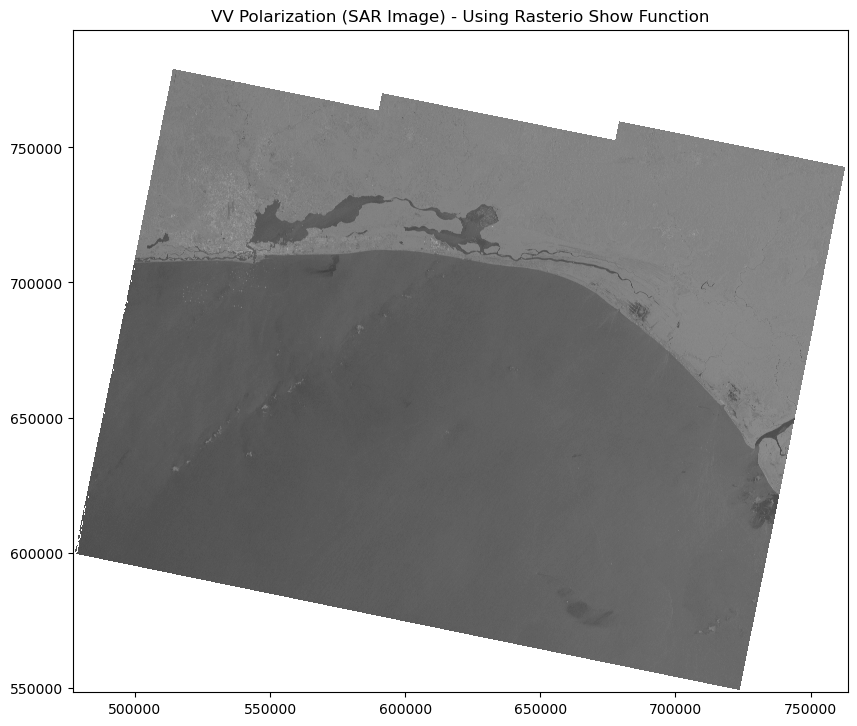

Image Bounds Info (meters): BoundingBox(left=477060.79402577307, bottom=548363.9438549243, right=763820.7940257731, top=793583.9438549243)
Affine Transform Info:
| 10.00, 0.00, 477060.79|
| 0.00,-10.00, 793583.94|
| 0.00, 0.00, 1.00|


Affine(10.0, 0.0, 477060.79402577307,
       0.0, -10.0, 793583.9438549243)

Width of the image: 286760.0 meters,28676 pixels
Height of the image: 245220.0 meters,24522 pixels


In [6]:
# Load and display the SAR images (VV and VH)
vv_path = os.path.join(path_xView3_images, scene_name_xView3, "VV_dB.tif")
vh_path = os.path.join(path_xView3_images, scene_name_xView3, "VH_dB.tif")

with rasterio.open(vv_path) as vv_src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(vv_src, ax=ax, cmap='gray')
    plt.title("VV Polarization (SAR Image) - Using Rasterio Show Function")
    plt.show()

    img_bounds = vv_src.bounds
    print("Image Bounds Info (meters):", img_bounds)
    print("Affine Transform Info:")
    print(vv_src.transform)
    display(vv_src.transform)
    
    # Get the pixel size from the affine transform (10x10 meters in our case)
    pixel_size_x = vv_src.transform[0]  # Pixel size in the x-direction (width)
    pixel_size_y = -vv_src.transform[4]  # Pixel size in the y-direction (height)

    # Calculate the width and height in meters
    width_meters = img_bounds.right - img_bounds.left
    height_meters = img_bounds.top - img_bounds.bottom
    
    # Calculate the number of pixels
    width_pixels = int(width_meters / pixel_size_x)
    height_pixels = int(height_meters / pixel_size_y)
    
    print(f"Width of the image: {width_meters} meters,{width_pixels} pixels")
    print(f"Height of the image: {height_meters} meters,{height_pixels} pixels")


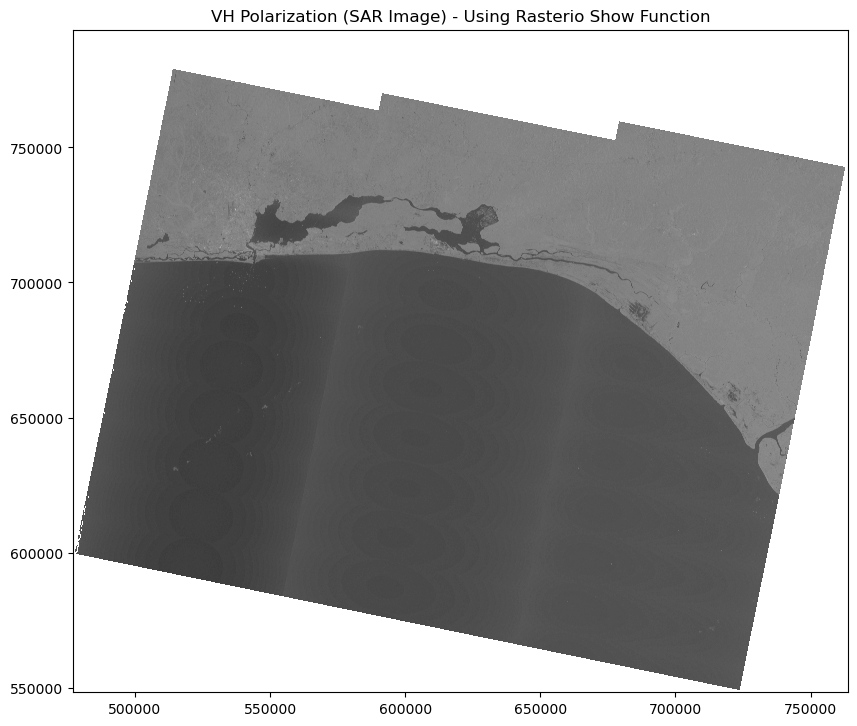

Image Bounds Info (meters): BoundingBox(left=477060.79402577307, bottom=548363.9438549243, right=763820.7940257731, top=793583.9438549243)
Affine Transform Info:
| 10.00, 0.00, 477060.79|
| 0.00,-10.00, 793583.94|
| 0.00, 0.00, 1.00|


Affine(10.0, 0.0, 477060.79402577307,
       0.0, -10.0, 793583.9438549243)

Width of the image: 286760.0 meters,28676 pixels
Height of the image: 245220.0 meters,24522 pixels


In [7]:
with rasterio.open(vh_path) as vh_src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(vh_src, ax=ax, cmap='gray')
    plt.title("VH Polarization (SAR Image) - Using Rasterio Show Function")
    plt.show()

    img_bounds = vh_src.bounds
    print("Image Bounds Info (meters):", img_bounds)
    print("Affine Transform Info:")
    print(vh_src.transform)
    display(vh_src.transform)
    
    # Get the pixel size from the affine transform (10x10 meters in our case)
    pixel_size_x = vh_src.transform[0]  # Pixel size in the x-direction (width)
    pixel_size_y = -vh_src.transform[4]  # Pixel size in the y-direction (height)

    # Calculate the width and height in meters
    width_meters = img_bounds.right - img_bounds.left
    height_meters = img_bounds.top - img_bounds.bottom
    
    # Calculate the number of pixels
    width_pixels = int(width_meters / pixel_size_x)
    height_pixels = int(height_meters / pixel_size_y)
    
    print(f"Width of the image: {width_meters} meters,{width_pixels} pixels")
    print(f"Height of the image: {height_meters} meters,{height_pixels} pixels")

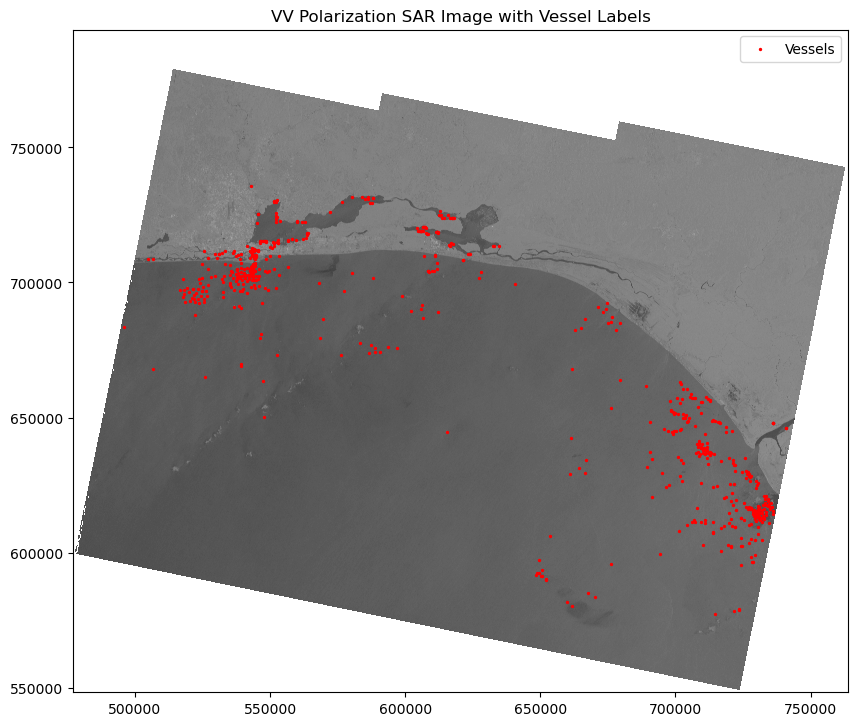

In [8]:
with rasterio.open(vv_path) as src:
    sar_crs = src.crs

# Create a GeoDataFrame from the label data
geometry = [Point(xy) for xy in zip(xView3_scene_df['detect_lon'], xView3_scene_df['detect_lat'])]
gdf = gpd.GeoDataFrame(xView3_scene_df, geometry=geometry, crs="EPSG:4326")  # Assuming lat/lon (WGS84)

# Reproject to the SAR CRS
gdf = gdf.to_crs(sar_crs)

# Display VV image with labeled detections as overlay
with rasterio.open(vv_path) as vv_src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(vv_src, ax=ax, cmap='gray')
    plt.grid(False)
    # Overlay the labels as points
    gdf.plot(ax=ax, marker='o', color='red', markersize=2, label="Vessels")
    plt.title("VV Polarization SAR Image with Vessel Labels")
    plt.legend()
    plt.show()

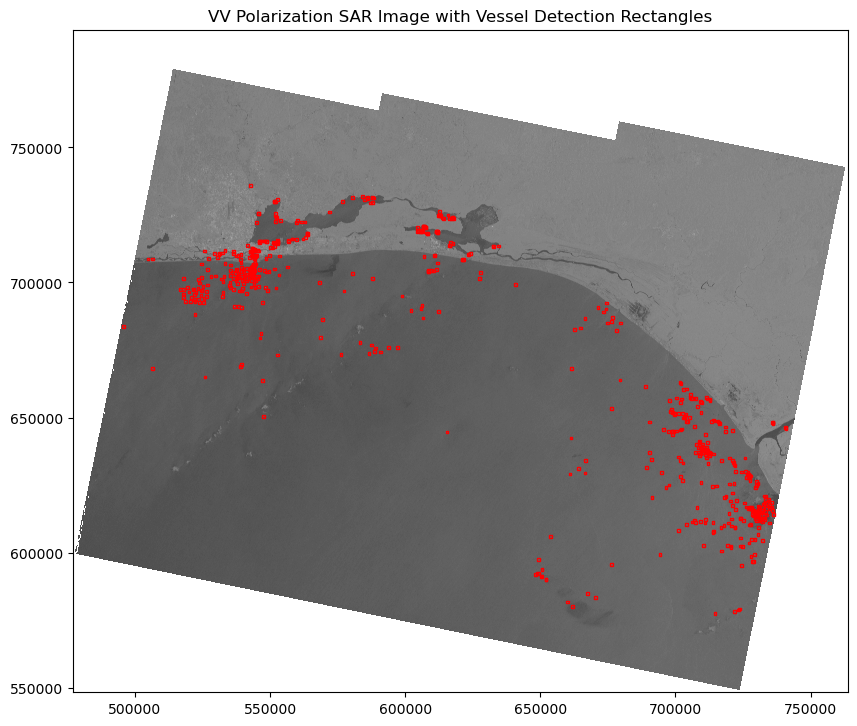

In [9]:
# Load the SAR image and plot
with rasterio.open(vv_path) as vv_src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(vv_src, ax=ax, cmap='gray')
    plt.grid(False)

    # Overlay the detections as rectangles around each detection point
    rect_width, rect_height = 1000, 1000  # Adjust to reasonable size based on scale
    for point in gdf.geometry:
        x, y = point.x, point.y
        rect = patches.Rectangle((x - rect_width / 2, y - rect_height / 2),
                                 rect_width, rect_height, linewidth=1,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
    plt.title("VV Polarization SAR Image with Vessel Detection Rectangles")
    plt.show()



In [10]:
display(gdf.geometry)

519     POINT (617160.794 723763.944)
520     POINT (617450.794 723983.944)
521     POINT (617710.794 724003.944)
522     POINT (661320.794 642433.944)
523     POINT (552640.794 715053.944)
                    ...              
1154    POINT (612210.794 689183.944)
1155    POINT (724770.794 602413.944)
1156    POINT (709410.794 625893.944)
1157    POINT (702800.794 633243.944)
1158    POINT (640780.794 699363.944)
Name: geometry, Length: 640, dtype: geometry

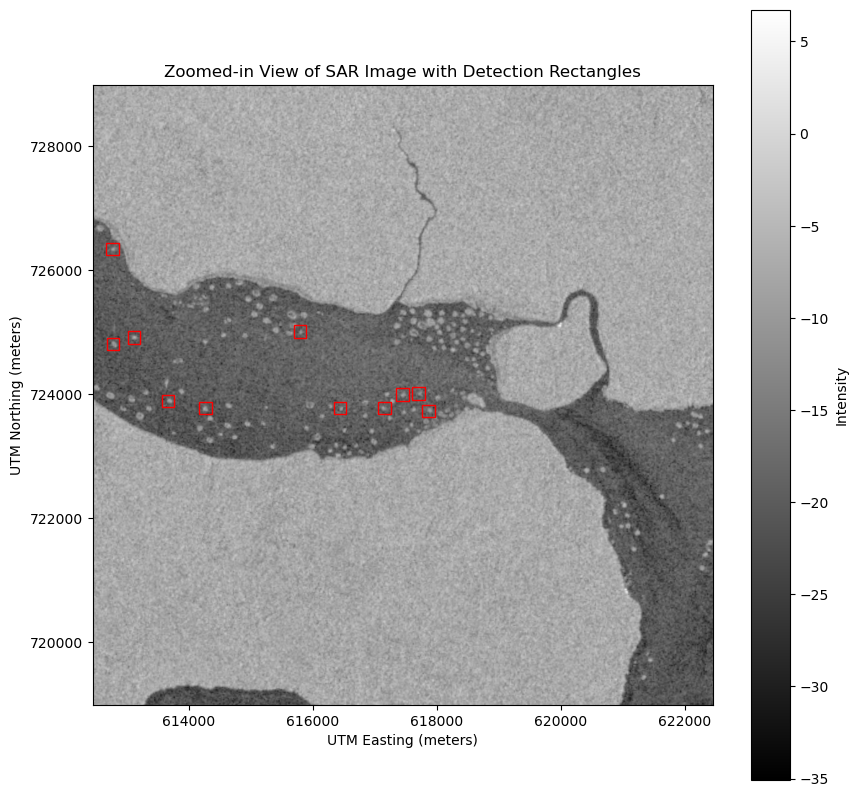

In [19]:
# The following code works great for visualizing different zoom windows surrounding the chosen center target, and manually drawing bounding boxes
# of a chosen size around all of the targets present within the specific window. It does, however, break down when the boundaries of the zoom window
# are not entirely within the pixels of the original image. I had issues fixing this and didn't want to spend too much time on it, but it has to do 
# with the GeoTIFF formatting of the image and the fact that the pixels which contain information are skew due to their mapping to geospatial coordinates

# Detection point example and zoom parameters
# Replace with the below index of your point of interest, in accordance with range of indices printed above for gdf.geometry
zoom_point = gdf.geometry[520]
desired_zoom_radius = 5000  # Desired zoom radius for zoom window in meters
rect_width = 200  # Manual bounding box width for visualizing detections

# Open the SAR image and get its extents
with rasterio.open(vv_path) as src:
    img_bounds = src.bounds
    img_width = img_bounds.right - img_bounds.left
    img_height = img_bounds.top - img_bounds.bottom

# Calculate the maximum zoom radius that stays within the image bounds
max_radius_x = min(zoom_point.x - img_bounds.left, img_bounds.right - zoom_point.x)
max_radius_y = min(zoom_point.y - img_bounds.bottom, img_bounds.top - zoom_point.y)
max_zoom_radius = min(max_radius_x, max_radius_y)

# Adjust the zoom radius if it exceeds the maximum allowable zoom radius
if desired_zoom_radius > max_zoom_radius:
    zoom_radius = max_zoom_radius
    print(f"Zoom radius too large, adjusting to maximum zoom radius: {zoom_radius} meters")
else:
    zoom_radius = desired_zoom_radius

# Calculate the bounds for the zoomed-in area
left = zoom_point.x - zoom_radius
right = zoom_point.x + zoom_radius
bottom = zoom_point.y - zoom_radius
top = zoom_point.y + zoom_radius

# Filter detections within the zoom window
filtered_gdf = gdf[(gdf.geometry.x >= left) & (gdf.geometry.x <= right) &
                   (gdf.geometry.y >= bottom) & (gdf.geometry.y <= top)]

# Open the SAR image and read the zoomed-in window
with rasterio.open(vv_path) as src:
    zoom_window = from_bounds(left, bottom, right, top, src.transform)
    zoomed_image = src.read(1, window=zoom_window)

# Plot the zoomed-in image
plt.figure(figsize=(10, 10))
plt.imshow(zoomed_image, cmap='gray', extent=(left, right, bottom, top))
plt.title("Zoomed-in View of SAR Image with Detection Rectangles")
plt.colorbar(label="Intensity")
plt.xlabel("UTM Easting (meters)")
plt.ylabel("UTM Northing (meters)")

# Add bounding boxes for all detections within the zoom window
for point in filtered_gdf.geometry:
    x, y = point.x, point.y
    rect = patches.Rectangle(
        (x - rect_width / 2, y - rect_width / 2),  # Center the rectangle on the detection point
        rect_width, rect_width,  # Width and height of the rectangle
        linewidth=1, edgecolor='red', facecolor='none'
    )
    plt.gca().add_patch(rect)

plt.show()


In [12]:
display(filtered_gdf)

,detect_lat,detect_lon,vessel_length_m,source,detect_scene_row,detect_scene_column,is_vessel,is_fishing,distance_from_shore_km,scene_id,confidence,top,left,bottom,right,detect_id,geometry
519,6.546716,4.059700,NaN,manual,6982,14010,True,NaN,1.348927,590dd08f71056cacv,LOW,6979.0,14004.0,6985.0,14016.0,590dd08f71056cacv_006.54671637800000016938_004...,POINT (617160.794 723763.944)
520,6.548701,4.062327,NaN,manual,6960,14039,True,NaN,1.111090,590dd08f71056cacv,LOW,6957.0,14035.0,6963.0,14043.0,590dd08f71056cacv_006.54870064400000018168_004...,POINT (617450.794 723983.944)
521,6.548877,4.064679,NaN,manual,6958,14065,True,NaN,1.076395,590dd08f71056cacv,LOW,6955.0,14061.0,6961.0,14069.0,590dd08f71056cacv_006.54887655699999982062_004...,POINT (617710.794 724003.944)
567,6.557103,4.023184,NaN,manual,6868,13606,True,NaN,0.843397,590dd08f71056cacv,MEDIUM,6865.0,13600.0,6871.0,13612.0,590dd08f71056cacv_006.55710304499999985239_004...,POINT (613120.794 724903.944)
568,6.556205,4.020107,NaN,manual,6878,13572,True,NaN,1.137506,590dd08f71056cacv,MEDIUM,6873.0,13568.0,6883.0,13576.0,590dd08f71056cacv_006.55620483900000028399_004...,POINT (612780.794 724803.944)
607,6.546771,4.033563,NaN,manual,6982,13721,True,NaN,1.057549,590dd08f71056cacv,LOW,6978.0,13718.0,6987.0,13724.0,590dd08f71056cacv_006.54677082400000021067_004...,POINT (614270.794 723763.944)
608,6.547867,4.028139,NaN,manual,6970,13661,True,NaN,0.985749,590dd08f71056cacv,LOW,6968.0,13656.0,6972.0,13666.0,590dd08f71056cacv_006.54786731699999968725_004...,POINT (613670.794 723883.944)
742,6.546730,4.053188,NaN,manual,6982,13938,True,NaN,1.389980,590dd08f71056cacv,LOW,6979.0,13934.0,6985.0,13942.0,590dd08f71056cacv_006.54673006899999965214_004...,POINT (616440.794 723763.944)
853,6.570043,4.020045,NaN,manual,6725,13571,True,NaN,0.304734,590dd08f71056cacv,LOW,6722.0,13568.0,6728.0,13574.0,590dd08f71056cacv_006.57004338900000028900_004...,POINT (612770.794 726333.944)
862,6.546341,4.066120,NaN,manual,6986,14081,True,NaN,0.943616,590dd08f71056cacv,LOW,6983.0,14077.0,6989.0,14085.0,590dd08f71056cacv_006.54634101200000007026_004...,POINT (617870.794 723723.944)


Affine Transformation: | 10.00, 0.00, 477060.79|
| 0.00,-10.00, 793583.94|
| 0.00, 0.00, 1.00|


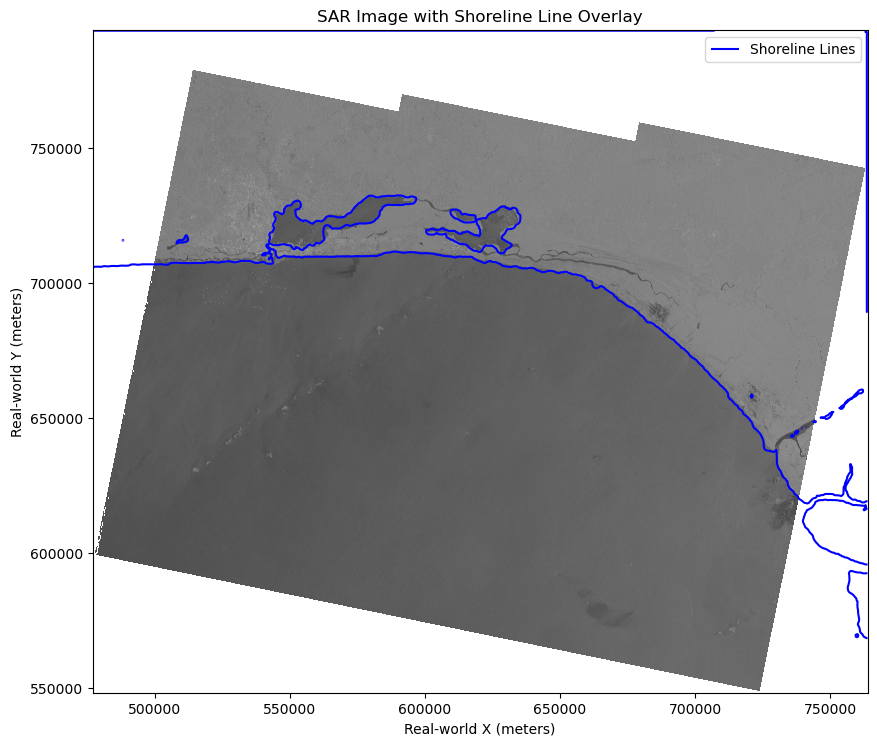

In [13]:
# Load shoreline data (assumed to be in pixel coordinates)
path_scene_shoredata = os.path.join(path_shoredata, f"{scene_name_xView3}_shoreline.npy")
shoreline_data = np.load(path_scene_shoredata, allow_pickle=True)

# Open the SAR image to get the affine transformation matrix
with rasterio.open(vv_path) as src:
    transform = src.transform  # Get the affine transformation matrix
    print(f"Affine Transformation: {transform}")

    # Transform pixel coordinates (x, y) to real-world coordinates
    lines = []  # Store multiple LineString objects
    for array in shoreline_data:
        geometry = []
        for point in array:
            # Pixel coordinates (x, y)
            x_pixel, y_pixel = point

            # Transform pixel coordinates to world coordinates (real-world CRS)
            x_world, y_world = xy(transform, x_pixel, y_pixel)
            geometry.append(Point(x_world, y_world))
        
        # Create a LineString for each segment (if it has enough points)
        if len(geometry) > 1:
            lines.append(LineString(geometry))

# Create a GeoDataFrame for the multiple LineStrings
line_gdf = gpd.GeoDataFrame(geometry=lines, crs=src.crs)  # Use the SAR image CRS

# Display the SAR image with the shoreline line overlay
with rasterio.open(vv_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='gray')

    # Plot the lines in world coordinates
    line_gdf.plot(ax=ax, color='blue', linewidth=1.5, label="Shoreline Lines")
    
    plt.title("SAR Image with Shoreline Line Overlay")
    plt.xlabel("Real-world X (meters)")
    plt.ylabel("Real-world Y (meters)")
    plt.legend()
    plt.show()


VV Bounds: BoundingBox(left=477060.79402577307, bottom=548363.9438549243, right=763820.7940257731, top=793583.9438549243)
Mask Bounds: BoundingBox(left=477060.79402577307, bottom=548583.9438549243, right=764060.7940257731, top=793583.9438549243)


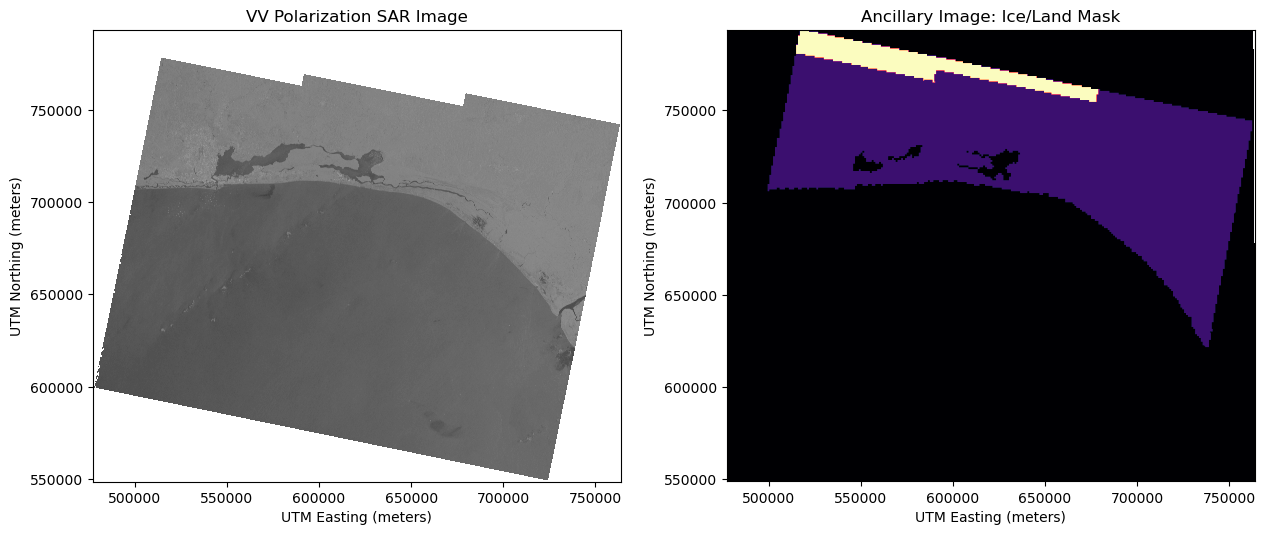

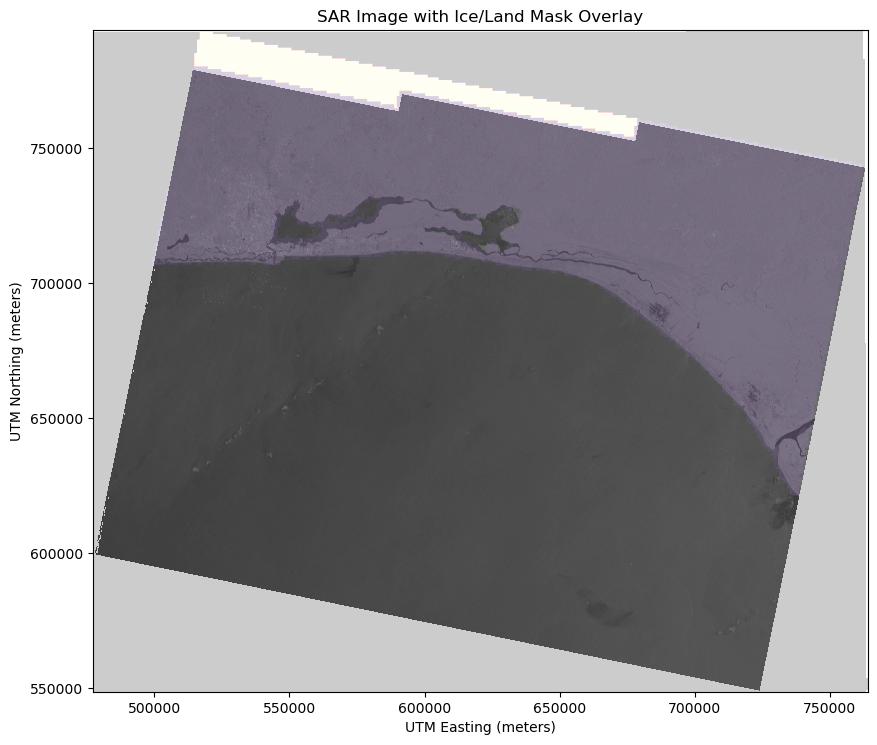

In [14]:
# Code for visualizing an ancillary image (i.e. land/ice mask) in relation to original SAR image. Keep in mind what was mentioned
# on the website for the dataset: "Rasters are consistently co-registered and projected in UTM with 10-meter pixels (SAR) or 
# 500-meter pixels (ancillary)". Therefore, resampling to match original SAR image pixels might be necessary if utilized for 
# certain purposes in future, as the bounds of the image and number of pixels are different. For now, just visualizing (including 
# overlaying) to inspect nature of images

# File paths for the SAR image and ancillary image
ice_land_mask_path = os.path.join(path_xView3_images, scene_name_xView3, "owiMask.tif")

# Open the SAR image and ancillary image
with rasterio.open(vv_path) as vv_src, rasterio.open(ice_land_mask_path) as mask_src:
    vv_bounds = vv_src.bounds
    mask_bounds = mask_src.bounds
    # Checking if the ancillary image has the same dimensions as the SAR image. Probably won't, considering the difference in pixel size (in m)
    if vv_bounds != mask_bounds:
        print("Warning: Bounds of the ancillary and SAR image are different.")
        print("VV Bounds:", vv_bounds)
        print("Mask Bounds:", mask_bounds)
    
    # Plotting side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    # Display the VV SAR image
    show(vv_src, ax=axs[0], cmap='gray')  # Display SAR image
    axs[0].set_title('VV Polarization SAR Image')
    axs[0].set_xlabel('UTM Easting (meters)')
    axs[0].set_ylabel('UTM Northing (meters)')
    
    # Display the ancillary mask image
    show(mask_src, ax=axs[1], cmap='magma')
    axs[1].set_title('Ancillary Image: Ice/Land Mask')
    axs[1].set_xlabel('UTM Easting (meters)')
    axs[1].set_ylabel('UTM Northing (meters)')

    # Overlay the ancillary image on the SAR image (VV Polarization)
    fig, ax = plt.subplots(figsize=(10, 10))
    show(vv_src, ax=ax, cmap='gray')  # Display SAR image
    show(mask_src, ax=ax, cmap='magma', alpha=0.2)
    plt.title('SAR Image with Ice/Land Mask Overlay')
    plt.xlabel('UTM Easting (meters)')
    plt.ylabel('UTM Northing (meters)')
    
    plt.show()

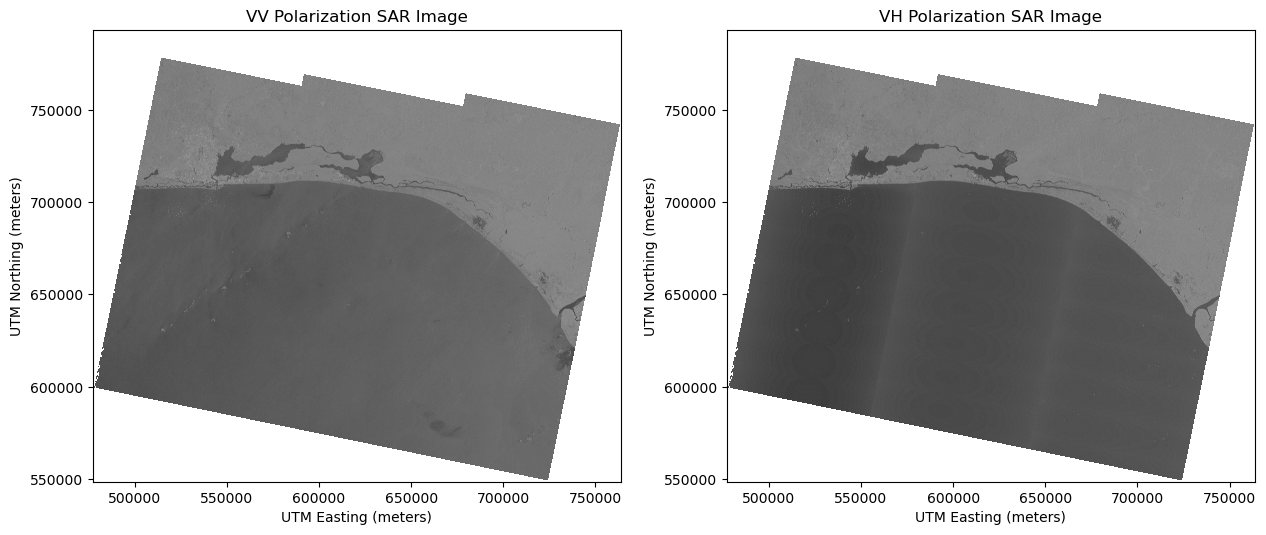

In [15]:
with rasterio.open(vv_path) as vv_src, rasterio.open(vh_path) as vh_src:
    # Plotting in a 2x2 grid
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))

    # Top-left: VV Polarization SAR Image
    show(vv_src, ax=axs[0], cmap='gray')  
    axs[0].set_title('VV Polarization SAR Image')
    axs[0].set_xlabel('UTM Easting (meters)')
    axs[0].set_ylabel('UTM Northing (meters)')

    # Top-right: VH Polarization SAR Image
    show(vh_src, ax=axs[1], cmap='gray')  
    axs[1].set_title('VH Polarization SAR Image')
    axs[1].set_xlabel('UTM Easting (meters)')
    axs[1].set_ylabel('UTM Northing (meters)')
